In [138]:
# Others
# ==============================================================================
import mlflow
import os
import boto3
from io import StringIO
import datetime
from datetime import date

# Graphs
# ==============================================================================
import seaborn as sns
from matplotlib import pyplot
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Modeling and Forecasting
# ==============================================================================
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima

In [22]:
os.environ["AWS_PROFILE"] = ("mlops") # fill in with your AWS profile. More info: https://docs.aws.amazon.com/sdk-for-java/latest/developer-guide/setup.html#setup-credentials
TRACKING_SERVER_HOST = "ec2-52-17-129-153.eu-west-1.compute.amazonaws.com" # fill in with the public DNS of the EC2 instance
mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:5000")

In [98]:
client = boto3.client('s3')
bucket_name = 'gas-prices-project'

object_key = 'data.csv'
csv_obj = client.get_object(Bucket=bucket_name, Key=object_key)
body = csv_obj['Body']
csv_string = body.read().decode('utf-8')

data = pd.read_csv(StringIO(csv_string))
data.tail()

,Date,Diesel
1890,2023-03-06,1.700
1891,2023-03-07,1.699
1892,2023-03-08,1.699
1893,2023-03-09,1.677
1894,2023-03-10,1.677


In [99]:
data['Diesel'] = data['Diesel'] .astype(float)
data['Date'] = pd.to_datetime(data['Date'],format="%Y-%m-%d")

In [100]:
data.sort_values(by='Date', inplace = True) 
data.drop_duplicates(data, inplace = True)
data = data.set_index('Date')
data.tail()


,Diesel
Date,
2023-03-06,1.700
2023-03-07,1.699
2023-03-08,1.699
2023-03-09,1.677
2023-03-10,1.677


# ==============================================================================
Analyzing and modeling
# ==============================================================================

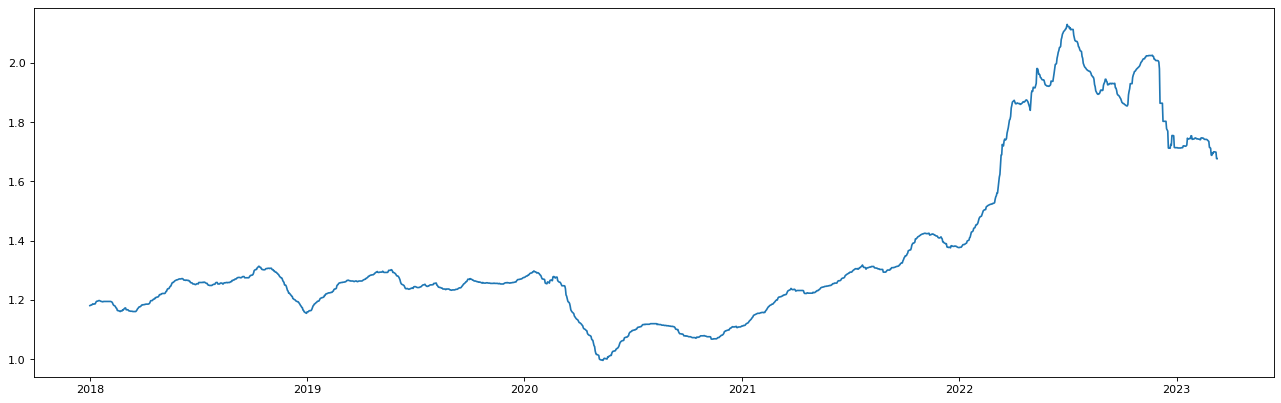

In [109]:
# Data graph (It looks non stationary)
figure(figsize=(20, 6), dpi=80)
plt.plot(data)

In [111]:
# ADF Test
def adf_test (data):
    result = adfuller(data)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, it's stationary")
    else:
        print("weak evidence against null hypothesis, it indicates data is non-stationary")


adf_test(data)


ADF Statistic: -1.106333
p-value: 0.712540
weak evidence against null hypothesis, it indicates data is non-stationary


In [112]:
# Differencing Technique (by 1 day)
data['Diesel_FirstDiff']=data['Diesel']-data['Diesel'].shift(1)
data.head()

,Diesel,Diesel_FirstDiff
Date,,
2018-01-01,1.181,NaN
2018-01-02,1.182,0.001
2018-01-03,1.183,0.001
2018-01-04,1.183,0.000
2018-01-05,1.185,0.002


In [113]:
# ADF Test (After one differencing,, it's stationary) I (arima) = 1
adf_test(data['Diesel_FirstDiff'].dropna())
data['Diesel_FirstDiff']=data['Diesel']-data['Diesel'].shift(1)


ADF Statistic: -6.558122
p-value: 0.000000
strong evidence against the null hypothesis, it's stationary


In [155]:
train = data['Diesel'].iloc[:-7]
test = data['Diesel'].iloc[-7:]

In [156]:
# Auto arima
arima_model = auto_arima(train, start_p=0, d=1, start_q=0, 
                         max_p=5, max_d=5, max_q=5, start_P=0,
                         D= 1, start_Q=0, max_P=5, max_D=5, 
                         max_Q=5, m=7, seasonal=True,
                         error_action='warn', trace=True,
                         suppress_warnings=True, stepwise=True,
                         random_state=20, n_fits=50)



Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-13336.343, Time=0.18 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-14007.748, Time=0.50 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=-14234.150, Time=1.06 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=-13401.047, Time=0.29 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=-14149.851, Time=0.82 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=-14343.543, Time=2.66 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=inf, Time=3.22 sec
 ARIMA(0,1,1)(0,1,3)[7]             : AIC=-14388.574, Time=2.38 sec
 ARIMA(0,1,1)(1,1,3)[7]             : AIC=-14350.560, Time=3.01 sec
 ARIMA(0,1,1)(0,1,4)[7]             : AIC=inf, Time=8.56 sec


In [ ]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1835
Model:             SARIMAX(0, 1, 3)x(1, 1, 3, 7)   Log Likelihood                7046.631
Date:                           Sun, 12 Mar 2023   AIC                         -14077.261
Time:                                   10:40:09   BIC                         -14033.178
Sample:                               01-01-2018   HQIC                        -14061.001
                                    - 01-09-2023                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2746      0.006     43.339      0.000       0.262       0.287
ma.L2          0.0955      0.013      7.411      0.000       0.070       0.121
ma.L3          0.1328      0.014      9.508      0.000       0.105       0.160
ar.S.L7       -0.4128      0.090     -4.598      0.000      -0.589      -0.237
ma.S.L7       -0.4602      0.088     -5.245      0.000      -0.632      -0.288
ma.S.L14      -0.2765      0.080     -3.459      0.001      -0.433      -0.120
ma.S.L21      -0.1352      0.016     -8.411      0.000      -0.167      -0.104
sigma2      2.603e-05   1.16e-07    224.062      0.000    2.58e-05    2.63e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):           1480532.55
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):              19.57   Skew:                            -5.56
Prob(H) (two-sided):                  0.00   Kurtosis:                       142.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
prediction = pd.DataFrame(arima_model.predict(n_periods=7), index=test.index)
prediction.columns = ['predicted price']
prediction

,predicted price
Date,
2023-03-04,NaN
2023-03-05,NaN
2023-03-06,NaN
2023-03-07,NaN
2023-03-08,NaN
2023-03-09,NaN
2023-03-10,NaN


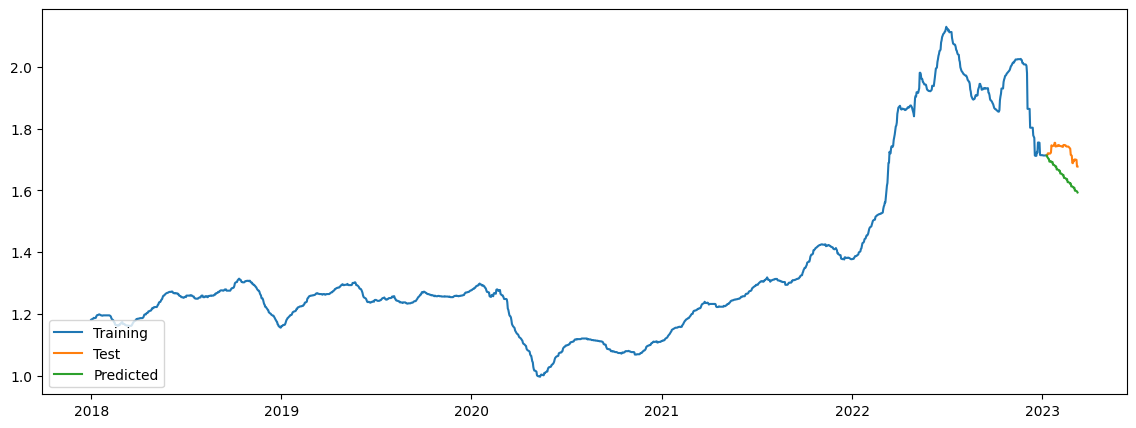

In [ ]:
plt.figure(figsize=(14,5))
plt.plot(train, label = 'Training')
plt.plot(test, label = 'Test')
plt.plot(prediction, label = 'Predicted')
plt.legend(loc = 'lower left')
plt.show()

In [129]:
# 12 months
data['Diesel_12tDiff']=data['Diesel']-data['Diesel'].shift(19)
adf_test(data['Diesel_12tDiff'].dropna())


ADF Statistic: -5.328934
p-value: 0.000005
strong evidence against the null hypothesis, it's stationary


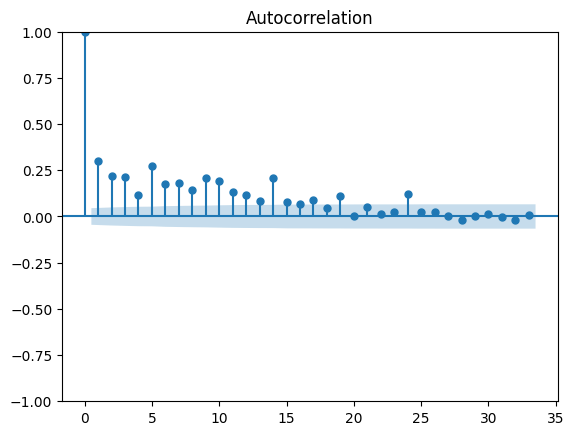

In [136]:
# ACF
acf = plot_acf(data['Diesel_FirstDiff'].dropna())

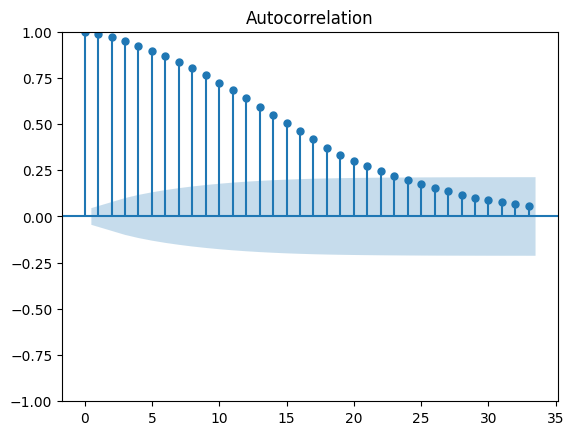

In [130]:
# ACF 19
acf = plot_acf(data['Diesel_12tDiff'].dropna())

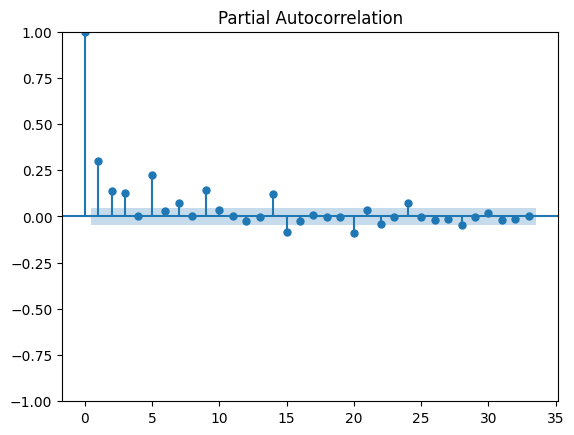

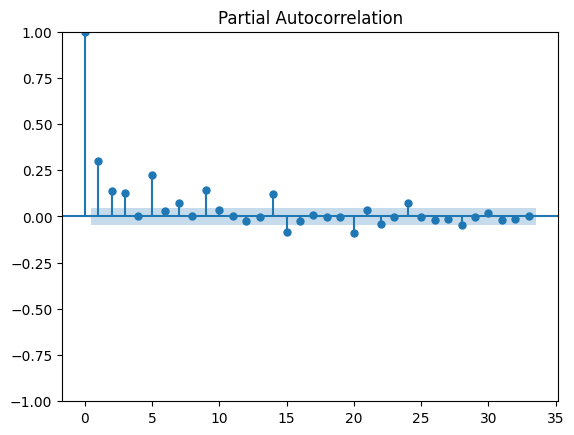

In [135]:
plot_pacf(data['Diesel_FirstDiff'].dropna())
plot_pacf(data['Diesel_12tDiff'].dropna())

In [ ]:
### split train and test data
from datetime import datetime,timedelta
train_dataset_end=datetime(1955,12,1)
test_dataset_end=datetime(1960,12,1)

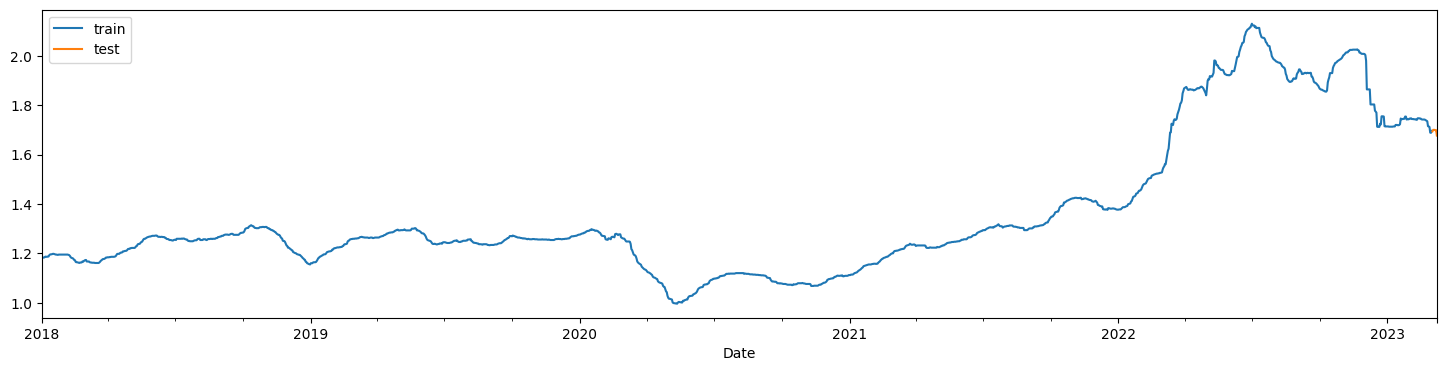

In [28]:
steps = 7
data_train = data_ts[:-steps]
data_test  = data_ts[-steps:]
fig, ax=plt.subplots(figsize=(18, 4))
data_train['Diesel'].plot(ax=ax, label='train')
data_test['Diesel'].plot(ax=ax, label='test')
ax.legend();

In [29]:
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 7
             )

forecaster.fit(y=data_train['Diesel'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6 7] 
Transformer for y: None 
Transformer for exog: None 
Window size: 7 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2018-01-01 00:00:00'), Timestamp('2023-03-02 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-03-10 16:29:18 
Last fit date: 2023-03-10 16:29:18 
Skforecast version: 0.6.0 
Python version: 3.9.4 

In [30]:
# Predictions
# ==============================================================================
steps = 7
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2023-03-03    1.70878
2023-03-04    1.71657
2023-03-05    1.72134
2023-03-06    1.73577
2023-03-07    1.73663
Freq: D, Name: pred, dtype: float64

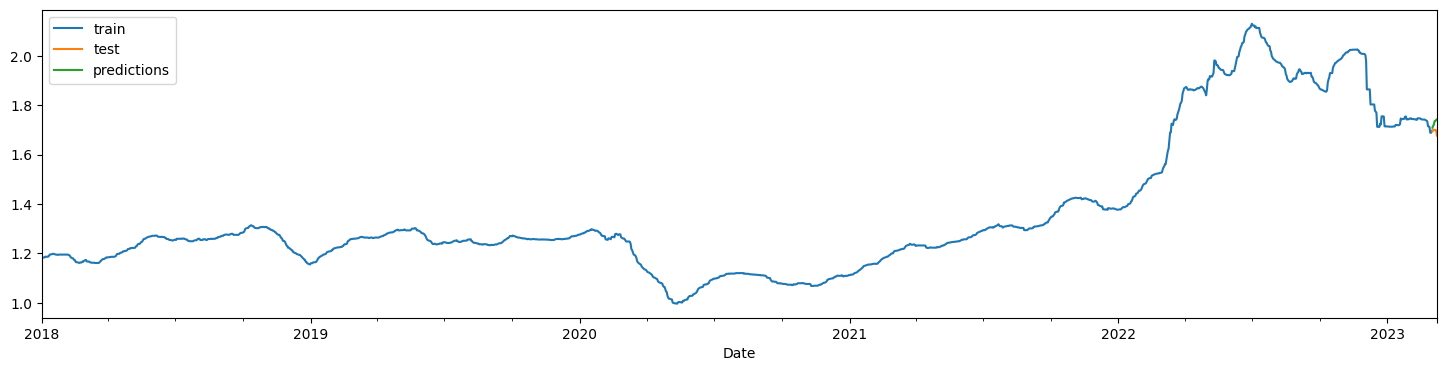

In [31]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(18, 4))
data_train['Diesel'].plot(ax=ax, label='train')
data_test['Diesel'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

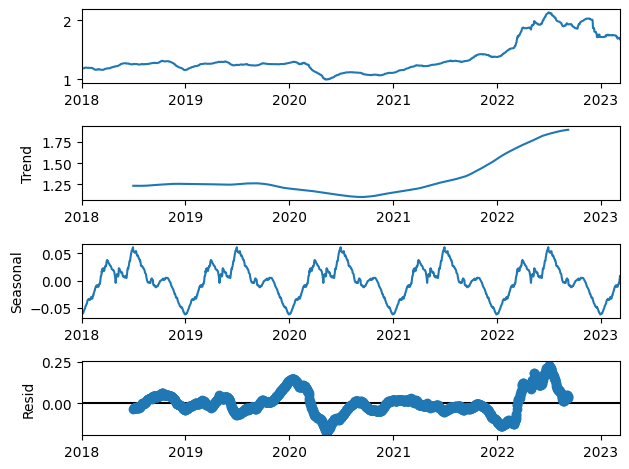

In [44]:
result = seasonal_decompose(data_ts, model='additive', period=365)
result.plot()
pyplot.show()

In [52]:
df_log=np.sqrt(data_ts['Diesel'])
df_diff=df_log.diff().dropna()

In [53]:
result=adfuller (df_diff)
print('Test Statistic: %f' %result[0])
print('p-value: %f' %result[1])
print('Critical values:')
for key, value in result[4].items ():
     print('\t%s: %.3f' %(key, value))

Test Statistic: -6.350687
p-value: 0.000000
Critical values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [81]:
train = data_ts.iloc[:-60]
test = data_ts.iloc[-60:]

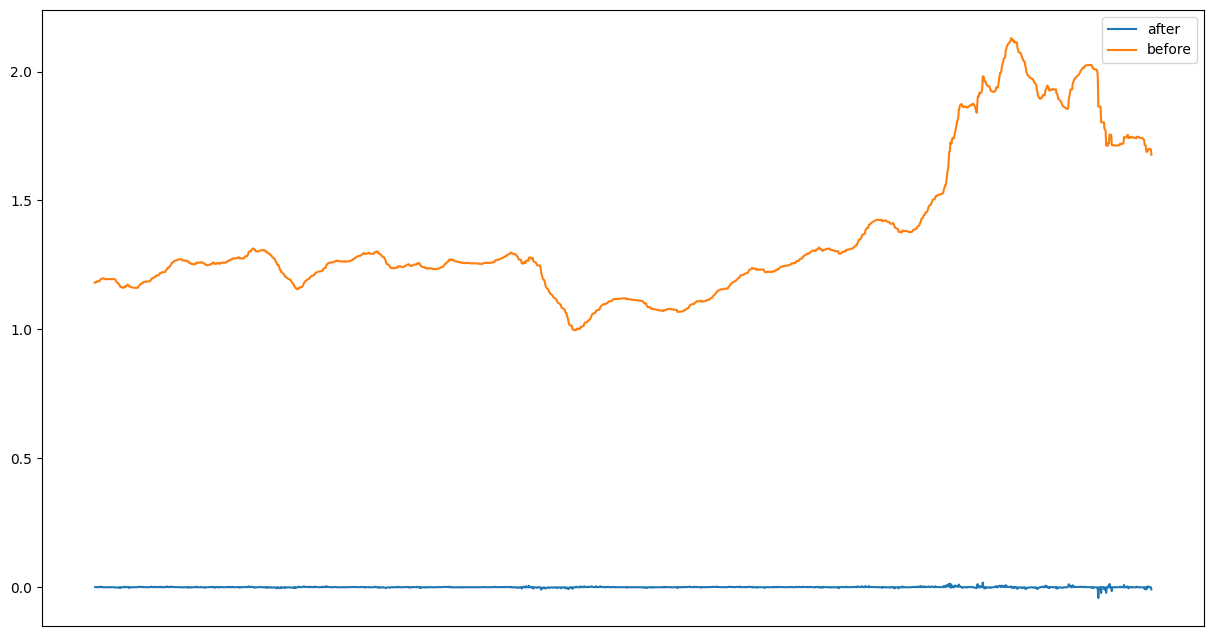

In [54]:
plt.figure(figsize=(15,8))
plt.plot(df_diff,label="after")
plt.plot(data_ts,label="before")
plt.tick_params(
    axis='x',        
    which='both',   
    bottom=False,      
    top=False,        
    labelbottom=False)
plt.legend()
plt.show() 

                               SARIMAX Results                                
Dep. Variable:                 Diesel   No. Observations:                 1893
Model:                 ARIMA(1, 1, 2)   Log Likelihood                9120.228
Date:                Sat, 11 Mar 2023   AIC                         -18232.455
Time:                        13:42:49   BIC                         -18210.273
Sample:                    01-02-2018   HQIC                        -18224.288
                         - 03-09-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6605      0.047    -14.049      0.000      -0.753      -0.568
ma.L1         -0.0525      0.046     -1.131      0.258      -0.143       0.038
ma.L2         -0.5657      0.031    -18.380      0.0

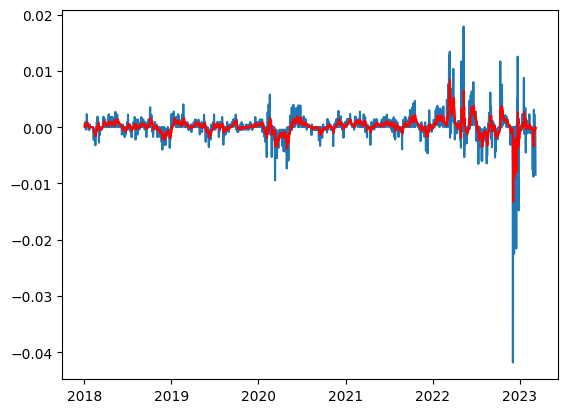

In [74]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA


model = sm.tsa.arima.ARIMA(df_diff, order=(1,1,2))
model_fit = model.fit()
print(model_fit.summary())

plt.plot(df_diff)
plt.plot(model_fit.fittedvalues, color='red')

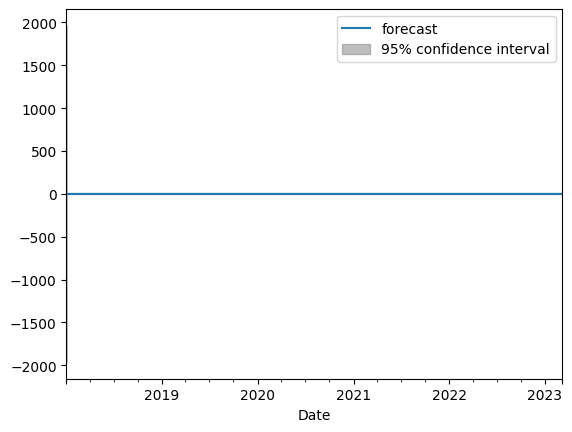

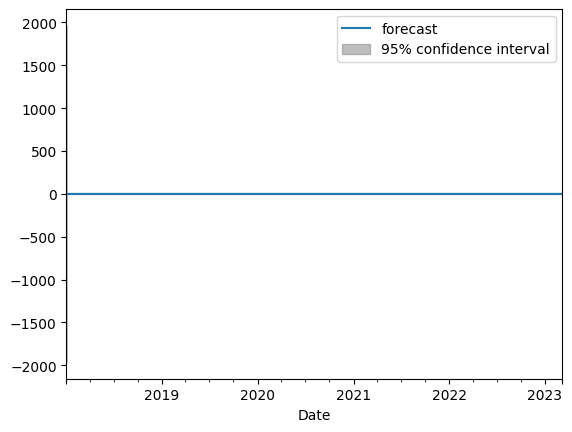

In [76]:
from statsmodels.graphics.tsaplots import plot_predict

plot_predict(model_fit)


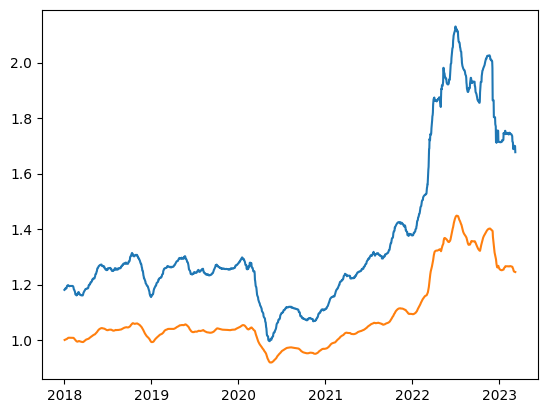

In [70]:
predictions_ARIMA_diff = pd.Series(model_fit.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_diff.iloc[0], index=df_diff.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(data_ts)
plt.plot(predictions_ARIMA)

In [84]:
TRACKING_SERVER_HOST = "ec2-52-17-129-153.eu-west-1.compute.amazonaws.com" # fill in with the public DNS of the EC2 instance
mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:5000")

In [85]:
print(f"tracking URI: '{mlflow.get_tracking_uri()}'")


tracking URI: 'http://ec2-52-17-129-153.eu-west-1.compute.amazonaws.com:5000'
